# Optimal exposure time

In a single frame, the variance of the noise is the sum of the variances of the read noise σ_r and of the signal. Since the signal has Poisson statistics, its variance is t * (I + N), with t the exposure time and I and N respectively the photon and thermal signals, in electrons per second. When stacking (summing) n frames, the noises add quadratically and the variance in the resulting image is thus given by

σ² = n * [ t * (I + N) + σ_r² ]

We decompose the photon signal I as the sum of the signal A from the astronomical object of interest and of the sky background brightness K, and rewrite the above as

σ² = n * t * A + n * [ t * (K + N) + σ_r² ]

The first term is the variance from the shot noise of the astronomical object, which depends only upon the total exposure time n * t. For that term, there is no difference between a single long exposure and several shorter ones.

The last two terms are the variance of the noises from the parasitic sources: read noise, sky background and thermal signal. With a cooled camera, the thermal noise can easily be negligible before the sky background. The ratio

R = ( σ_r² + t * K ) / ( t * K )

represents the noise relative to the ideal detector case (no read noise, no thermal noise). Interestingly, it does not depend upon the number of exposures. We can then define a maximum acceptable value for this ratio, so that

R < (1 + ε)²

with ε representing the acceptable increase in noise, e.g. 0.1 for 10%. We then derive the corresponding exposure time

t = σ_r² / { K * [ (1 + ε)² - 1] }

Exposure times larger than that will only provide marginal reduction of the noise in the stack.

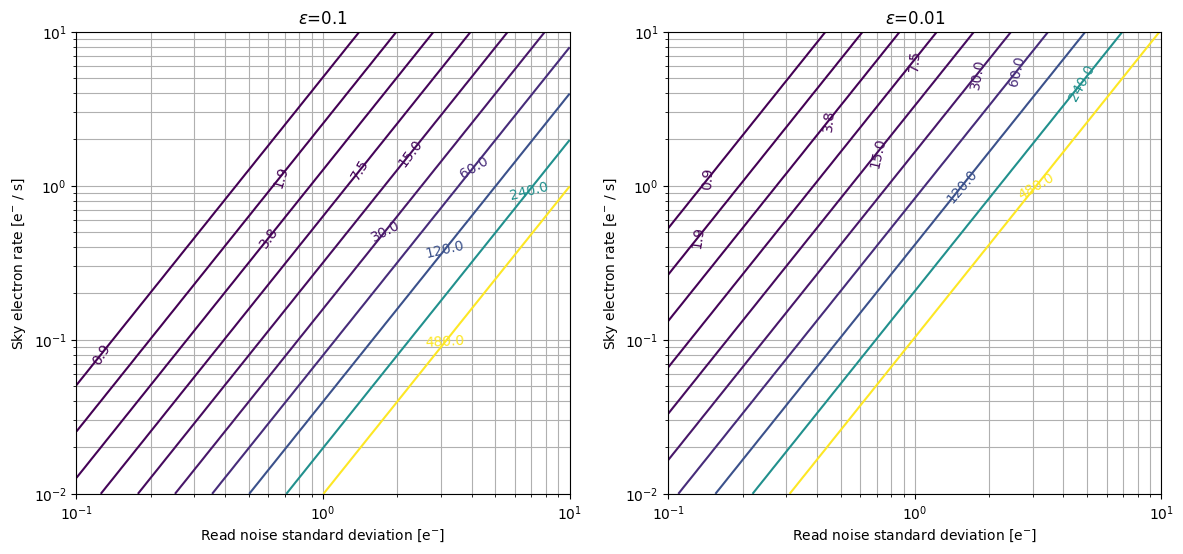

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def optimal_exposure(sigma_rn, sk, eps):
    """
    Computes the optimal exposure time given the read noise, sky electron rate and acceptable noise increase.
    :param sigma_rn: standard deviation of the read noise [electrons]
    :param sk: sky background brightness rate [electrons / second]
    :param eps: acceptable noise increase (e.g. 0.01 = 1%)
    :return: optimal exposure time [seconds]
    """
    return sigma_rn ** 2 / ( sk * ( ( 1 + eps ) ** 2 - 1) )

def epsilon_noise(sigma_rn, expt, sk):
    """
    Computes the noise increase given the read noise and sky electron rate.
    :param sigma_rn: standard deviation of the read noise [electrons]
    :param expt: exposure time [seconds]
    :param sk: sky background brightness rate [electrons / second]
    :return: additional noise
    """
    return np.sqrt((sigma_rn ** 2 + expt * sk)/ ( expt * sk )) - 1

epsilon = [0.1, 0.01]

read_noise_values = 10 ** np.linspace(-1, 1, 100)  # regular sampling in log
sky_background_values = 10 ** np.linspace(-1, 1, 100)
read_noise_grid, sky_background_grid = np.meshgrid(read_noise_values, sky_background_values)  # grid of values at the sampling values defined above

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for e, ax in zip(epsilon, axes.flatten()):
    c = ax.contour(read_noise_grid,
                   sky_background_grid,
                   optimal_exposure(read_noise_grid, sky_background_grid, e),
                   levels=[0.9375, 1.875, 3.75, 7.5, 15, 30, 60, 120, 240, 480])
    ax.clabel(c, c.levels, inline=False)
    ax.set_xlabel('Read noise standard deviation [e$^{-}$]')
    ax.set_ylabel('Sky electron rate [e$^{-}$ / s]')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid('on', which='major')
    ax.grid('on', which='minor')
    ax.set_title(f'$\epsilon$={e}')

For a given ε, the optimum exposure time is proportional to the ratio σ_r² / K. The higher the read noise, the longer the required exposure time. The brighter the sky background, the shorter the required exposure time. For example, for a read noise of 1.4 electrons (gain setting 100) and a sky electron rate of 0.34 electrons / s ([Bortle 4 sky, broad band](https://tools.sharpcap.co.uk/)), one gets

In [2]:
t = optimal_exposure(1.4, 0.34, 0.1)
print(f'{t:0.1f} s')

27.5 s


for ε = 0.1 (10% acceptable noise increase), and

In [3]:
t = optimal_exposure(1.4, 0.34, 0.01)
print(f'{t:0.1f} s')

286.8 s


for ε = 0.01 (1% acceptable noise increase). These values are to be compared with the maximum exposure time allowed by the tracking system (see [1.3.3](README.md#13-notes)).
For a read noise of 3.4 electrons (gain setting 99), these values become

In [4]:
for e in [0.1, 0.01]:
    t = optimal_exposure(3.4, 0.34, e)
    print(f'ε={e:.2f}:  {t:0.1f}s')

ε=0.10:  161.9s
ε=0.01:  1691.5s


Which demonstrates the importance of low read noise, and justifies operating at Gain 100 despite the lower dynamic range compared to lower gain setting (see the [ASI 2600 datasheet](https://astronomy-imaging-camera.com/manuals/ASI2600_Manual_EN.pdf)).

For narrowband (7 nm) imaging, the sky electron rate goes down to 0.02 electrons / s, and we get

In [5]:
for e in [0.1, 0.01]:
    t = optimal_exposure(1.4, 0.02, e)
    print(f'ε={e:.2f}:  {t:0.1f}s')

ε=0.10:  466.7s
ε=0.01:  4875.6s


which is beyond the capabilities of the tracking system. With guiding, 8 minute exposures would be OK, but more than one hour is in any case too long given the likelihood to be affected by satellite trails, clouds, or the necessity to dither. Inverting the problem, we can also compute the amount of added noise for a given exposure time

In [6]:
for t in [30, 60, 90]:
    epsilon = epsilon_noise(1.4, 0.02, t)
    print(f'{t:d}s:  ε={epsilon:.02f}')

30s:  ε=1.07
60s:  ε=0.62
90s:  ε=0.45


which means a 107% increase in noise at 30s and 45% at 90s. Guiding is definitely needed for narrowband imaging.